In [1]:
# Get Noto font qwenagent venv
!sudo apt-get update
!apt-get install fonts-noto-cjk 

获取:1 http://mirrors.aliyun.com/ubuntu jammy InRelease [270 kB]
获取:2 http://mirrors.aliyun.com/ubuntu jammy-security InRelease [129 kB]
获取:3 http://mirrors.aliyun.com/ubuntu jammy-updates InRelease [128 kB]         
获取:4 http://mirrors.aliyun.com/ubuntu jammy-backports InRelease [127 kB]       
获取:5 http://mirrors.aliyun.com/ubuntu jammy/main amd64 Packages [1,792 kB]
获取:6 https://developer.download.nvidia.cn/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
获取:7 https://developer.download.nvidia.cn/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,604 kB]
获取:8 http://mirrors.aliyun.com/ubuntu jammy/multiverse amd64 Packages [266 kB]
获取:9 http://mirrors.aliyun.com/ubuntu jammy/universe amd64 Packages [17.5 MB]
获取:10 http://mirrors.aliyun.com/ubuntu jammy/restricted amd64 Packages [164 kB]
获取:11 http://mirrors.aliyun.com/ubuntu jammy-security/multiverse amd64 Packages [47.7 kB]
获取:12 http://mirrors.aliyun.com/ubuntu jammy-security/universe amd64 Packages [1,243 kB]
获取:13 http://m

In [2]:
import base64
from openai import OpenAI
# Set OpenAI's API key and API base to use vLLM's API server.
openai_api_key = "EMPTY"
openai_api_base = "http://localhost:8000/v1"
client = OpenAI(
    api_key=openai_api_key,
    base_url=openai_api_base,
)
image_path = "/mnt/workspace/LLaMA-Factory/test_image/bettercallsaul.png"
with open(image_path, "rb") as f:
    encoded_image = base64.b64encode(f.read())
encoded_image_text = encoded_image.decode("utf-8")
base64_qwen = f"data:image;base64,{encoded_image_text}"
chat_response = client.chat.completions.create(
    model="Qwen2.5-VL-7B-Instruct",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": base64_qwen
                    },
                },
                {"type": "text", "text": "Who is the man in the image?"},
            ],
        },
    ],
)
# 提取所需的字段
simplified_response = {
    "id": chat_response.id,  # 提取 id
    "content": chat_response.choices[0].message.content,  # 提取生成的文本内容
    "model": chat_response.model  # 提取模型名称
}

# 打印简化后的响应
print("Simplified response:", simplified_response)

Simplified response: {'id': 'chatcmpl-de47f412ae8c4fe597c7d8aad3a8fd2a', 'content': 'The man in the image is Bob Odenkirk, an American actor and comedian. He is best known for his role as Saul Goodman in the television series "Better Call Saul," which is a prequel to the popular show "Breaking Bad." In this image, he appears to be portraying his character Saul Goodman, sitting at a desk with a mug that reads "World\'s Greatest Lawyer."', 'model': 'Qwen2.5-VL-7B-Instruct'}


In [3]:
# Get Noto font
# !apt-get install fonts-noto-cjk 

import os
from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO
from bs4 import BeautifulSoup, Tag
from pathlib import Path
import re

# Function to draw bounding boxes and text on images based on HTML content
def draw_bbox(image_path, resized_width, resized_height, full_predict):
    if image_path.startswith("http"):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path)
    original_width = image.width
    original_height = image.height
    
    # Parse the provided HTML content
    soup = BeautifulSoup(full_predict, 'html.parser')
    # Extract all elements that have a 'data-bbox' attribute
    elements_with_bbox = soup.find_all(attrs={'data-bbox': True})

    filtered_elements = []
    for el in elements_with_bbox:
        if el.name == 'ol':
            continue  # Skip <ol> tags
        elif el.name == 'li' and el.parent.name == 'ol':
            filtered_elements.append(el)  # Include <li> tags within <ol>
        else:
            filtered_elements.append(el)  # Include all other elements

    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", 20)
    draw = ImageDraw.Draw(image)
    
    # Draw bounding boxes and text for each element
    for element in filtered_elements:
        bbox_str = element['data-bbox']
        text = element.get_text(strip=True)
        x1, y1, x2, y2 = map(int, bbox_str.split())
        
        # Calculate scaling factors
        scale_x = resized_width / original_width
        scale_y = resized_height / original_height
        
        # Scale coordinates accordingly
        x1_resized = int(x1 / scale_x)
        y1_resized = int(y1 / scale_y)
        x2_resized = int(x2 / scale_x)
        y2_resized = int(y2 / scale_y)
        
        if x1_resized > x2_resized:
            x1_resized, x2_resized = x2_resized, x1_resized
        if y1_resized > y2_resized:
            y1_resized, y2_resized = y2_resized, y1_resized
            
        # Draw bounding box
        draw.rectangle([x1_resized, y1_resized, x2_resized, y2_resized], outline='red', width=2)
        # Draw associated text
        draw.text((x1_resized, y2_resized), text, fill='black', font=font)

    # Display the image
    image.show()

# Function to clean and format HTML content
def clean_and_format_html(full_predict):
    soup = BeautifulSoup(full_predict, 'html.parser')
    
    # Regular expression pattern to match 'color' styles in style attributes
    color_pattern = re.compile(r'\bcolor:[^;]+;?')

    # Find all tags with style attributes and remove 'color' styles
    for tag in soup.find_all(style=True):
        original_style = tag.get('style', '')
        new_style = color_pattern.sub('', original_style)
        if not new_style.strip():
            del tag['style']
        else:
            new_style = new_style.rstrip(';')
            tag['style'] = new_style
            
    # Remove 'data-bbox' and 'data-polygon' attributes from all tags
    for attr in ["data-bbox", "data-polygon"]:
        for tag in soup.find_all(attrs={attr: True}):
            del tag[attr]

    classes_to_update = ['formula.machine_printed', 'formula.handwritten']
    # Update specific class names in div tags
    for tag in soup.find_all(class_=True):
        if isinstance(tag, Tag) and 'class' in tag.attrs:
            new_classes = [cls if cls not in classes_to_update else 'formula' for cls in tag.get('class', [])]
            tag['class'] = list(dict.fromkeys(new_classes))  # Deduplicate and update class names

    # Clear contents of divs with specific class names and rename their classes
    for div in soup.find_all('div', class_='image caption'):
        div.clear()
        div['class'] = ['image']

    classes_to_clean = ['music sheet', 'chemical formula', 'chart']
    # Clear contents and remove 'format' attributes of tags with specific class names
    for class_name in classes_to_clean:
        for tag in soup.find_all(class_=class_name):
            if isinstance(tag, Tag):
                tag.clear()
                if 'format' in tag.attrs:
                    del tag['format']

    # Manually build the output string
    output = []
    for child in soup.body.children:
        if isinstance(child, Tag):
            output.append(str(child))
            output.append('\n')  # Add newline after each top-level element
        elif isinstance(child, str) and not child.strip():
            continue  # Ignore whitespace text nodes
    complete_html = f"""```html\n<html><body>\n{" ".join(output)}</body></html>\n```"""
    return complete_html

In [4]:
from openai import OpenAI
import os
import base64
#  base 64 编码格式
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


# @title inference function with API
def inference_with_api(image_path, prompt, sys_prompt="You are a helpful assistant.", model_id="Qwen2.5-VL-7B-Instruct", min_pixels=512*28*28, max_pixels=2048*28*28):
    base64_image = encode_image(image_path)
    llm_cfg = {
        'model': 'Qwen2.5-VL-7B-Instruct',  # 模型名称
        'model_server': 'http://localhost:8000/v1',  # 本地服务器地址
        'api_key': 'EMPTY',  # 本地服务器无需 API Key
        'generate_cfg': {
            'top_p': 0.8,       # 核心采样概率
            'max_tokens': 1024   # 生成的最大 token 数
        }
    }
    client = OpenAI(
        api_key=llm_cfg['api_key'],  # API Key
        base_url=llm_cfg['model_server']  # 本地服务器地址
        # #If the environment variable is not configured, please replace the following line with the Dashscope API Key: api_key="sk-xxx".
        # api_key=os.getenv('DASHSCOPE_API_KEY'),
        # # api_key='EMPTY',
        # base_url="https://dashscope-intl.aliyuncs.com/compatible-mode/v1",
    )


    messages=[
        {
            "role": "system",
            "content": [{"type":"text","text": sys_prompt}]},
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "min_pixels": min_pixels,
                    "max_pixels": max_pixels,
                    # Pass in BASE64 image data. Note that the image format (i.e., image/{format}) must match the Content Type in the list of supported images. "f" is the method for string formatting.
                    # PNG image:  f"data:image/png;base64,{base64_image}"
                    # JPEG image: f"data:image/jpeg;base64,{base64_image}"
                    # WEBP image: f"data:image/webp;base64,{base64_image}"
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                },
                {"type": "text", "text": prompt},
            ],
        }
    ]
    completion = client.chat.completions.create(
        model = model_id,
        messages = messages,
       
    )
    return completion.choices[0].message.content

756 588
```html
<html><body>
<div class="image" data-bbox="10 12 458 376"><img data-bbox="10 12 458 376"/></div> 
 <p data-bbox="10 379 458 420">Table 7: Performance comparison of HLLM with SOTA models, SASRec*, means SASRec uses the ViT as an image encoder for item encoding and trained by BCE loss from (Cheng et al., 2024). * indicates the result is reproduced by us. $i$ indicates the number of negative samples and the batch size are increased from 512 and 128 to 28k and 512, respectively. “Scratch” indicates both Item LLM and User LLM are trained from scratch.</p> 
 <div class="image" data-bbox="10 423 458 500"><img data-bbox="10 423 458 500"/></div> 
 <p data-bbox="10 503 458 544">Table 8 show that while freezing the Item LLM leads to some metric decreases, performance still exceeds ID-based models, proving item caching is more effective. Given that user behaviors in industrial scenarios far exceed the numbers of items, HLLM’s training and serving costs can match those of ID-based m

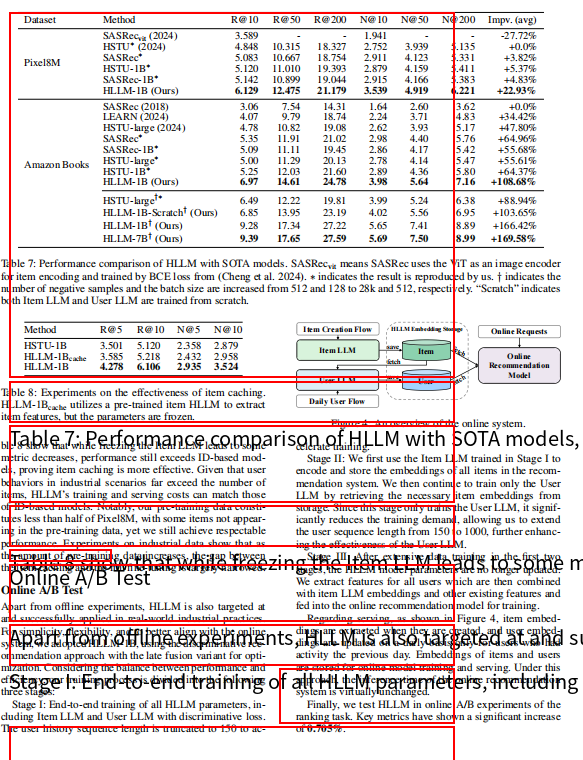

```html
<html><body>
<div class="image"><img/></div> 
 <p>Table 7: Performance comparison of HLLM with SOTA models, SASRec*, means SASRec uses the ViT as an image encoder for item encoding and trained by BCE loss from (Cheng et al., 2024). * indicates the result is reproduced by us. $i$ indicates the number of negative samples and the batch size are increased from 512 and 128 to 28k and 512, respectively. “Scratch” indicates both Item LLM and User LLM are trained from scratch.</p> 
 <div class="image"><img/></div> 
 <p>Table 8 show that while freezing the Item LLM leads to some metric decreases, performance still exceeds ID-based models, proving item caching is more effective. Given that user behaviors in industrial scenarios far exceed the numbers of items, HLLM’s training and serving costs can match those of ID-based models. Our pre-training data constitutes about half of Pixel8M, but we still achieve respectable performance. Experiments on industrial data show that as the amount of 

In [5]:
img_url = "/mnt/workspace/LLaMA-Factory/test_image/HLLM_with_graph_and_table.png"
image = Image.open(img_url)

system_prompt="You are an AI specialized in recognizing and extracting text from images. Your mission is to analyze the image document and generate the result in QwenVL Document Parser HTML format using specified tags while maintaining user privacy and data integrity."
prompt =  "QwenVL HTML "

## Use a local HuggingFace model to inference.
# output, input_height, input_width = inference(img_url, prompt)




## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'EMPTY'
min_pixels = 512*28*28
max_pixels = 2048*28*28
image = Image.open(img_url)
width, height = image.size
input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
output = inference_with_api(img_url, prompt, min_pixels=min_pixels, max_pixels=max_pixels)


# Visualization
print(input_height, input_width)
print(output)
draw_bbox(img_url, input_width, input_height, output)

ordinary_html = clean_and_format_html(output)
print(ordinary_html)

In [7]:
# generate ordinary html

# img_url = "assets/document_parsing/docparsing_example5.png"
prompt = "图片解析成html"
image = Image.open(img_url)

## Use a local HuggingFace model to inference.
# output, input_height, input_width = inference(img_url, prompt)
# print(output)

## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here'
min_pixels = 512*28*28
max_pixels = 2048*28*28
image = Image.open(img_url)
width, height = image.size
input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
output = inference_with_api(img_url, prompt, min_pixels=min_pixels, max_pixels=max_pixels)
print(output)

```html
<html><body>
<div class="table" style="text-align: center"><table><tbody><tr><td style="text-align: center">Dataset</td><td style="text-align: center">Method</td><td style="text-align: center">R@ 10</td><td style="text-align: center">R@ 50</td><td style="text-align: center">R@ 200</td><td style="text-align: center">N@ 10</td><td style="text-align: center">N@ 50</td><td style="text-align: center">N@ 200</td><td style="text-align: center">Impv. (avg)</td></tr><tr><td rowspan="13" style="text-align: center">Pixel8M</td><td style="text-align: center">SASRecup (2024)</td><td style="text-align: center">3.589</td><td style="text-align: center">-</td><td style="text-align: center">-1.941</td><td style="text-align: center">-</td><td style="text-align: center">-</td><td style="text-align: center">-</td><td style="text-align: center">-27.72%</td></tr><tr><td style="text-align: center">HSTU* (2024)</td><td style="text-align: center">4.848</td><td style="text-align: center">10.315</td><td s

In [42]:
import json
import random
import io
import ast
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor
from IPython.display import Markdown, display
from openai import OpenAI
import os
import base64


def plot_text_bounding_boxes(image_path, bounding_boxes, input_width, input_height):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        image_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = Image.open(image_path)
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=10)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(ast.literal_eval(bounding_boxes)):
      color = 'green'

      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["bbox_2d"][1]/input_height * height)
      abs_x1 = int(bounding_box["bbox_2d"][0]/input_width * width)
      abs_y2 = int(bounding_box["bbox_2d"][3]/input_height * height)
      abs_x2 = int(bounding_box["bbox_2d"][2]/input_width * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      # Draw the bounding box
      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=1
      )

      # Draw the text
      if "text_content" in bounding_box:
        draw.text((abs_x1, abs_y2), bounding_box["text_content"], fill=color, font=font)

    # Display the image
    img.show()

# @title Parsing JSON output
def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

# @title inference function
def inference(image_path, prompt, sys_prompt="You are a helpful assistant.", max_new_tokens=4096, return_input=False):
    image = Image.open(image_path)
    image_local_path = "file://" + image_path
    messages = [
        {"role": "system", "content": sys_prompt},
        {"role": "user", "content": [
                {"type": "text", "text": prompt},
                {"image": image_local_path},
            ]
        },
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    print("text:", text)
    # image_inputs, video_inputs = process_vision_info([messages])
    inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt")
    inputs = inputs.to('cuda')

    output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    if return_input:
        return output_text[0], inputs
    else:
        return output_text[0]
    



#  base 64 编码格式
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


# @title inference function with API
def inference_with_api(image_path, prompt, sys_prompt="You are a helpful assistant.", model_id="Qwen2.5-VL-7B-Instruct", min_pixels=512*28*28, max_pixels=2048*28*28):
    base64_image = encode_image(image_path)
    llm_cfg = {
        'model': 'Qwen2.5-VL-7B-Instruct',  # 模型名称
        'model_server': 'http://localhost:8000/v1',  # 本地服务器地址
        'api_key': 'EMPTY',  # 本地服务器无需 API Key
        'generate_cfg': {
            'top_p': 0.8,       # 核心采样概率
            'max_tokens': 2048   # 生成的最大 token 数
        }
    }
    client = OpenAI(
        api_key=llm_cfg['api_key'],  # API Key
        base_url=llm_cfg['model_server']  # 本地服务器地址
        # #If the environment variable is not configured, please replace the following line with the Dashscope API Key: api_key="sk-xxx".
        # api_key=os.getenv('DASHSCOPE_API_KEY'),
        # # api_key='EMPTY',
        # base_url="https://dashscope-intl.aliyuncs.com/compatible-mode/v1",
    )


    messages=[
        {
            "role": "system",
            "content": [{"type":"text","text": sys_prompt}]},
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "min_pixels": min_pixels,
                    "max_pixels": max_pixels,
                    # Pass in BASE64 image data. Note that the image format (i.e., image/{format}) must match the Content Type in the list of supported images. "f" is the method for string formatting.
                    # PNG image:  f"data:image/png;base64,{base64_image}"
                    # JPEG image: f"data:image/jpeg;base64,{base64_image}"
                    # WEBP image: f"data:image/webp;base64,{base64_image}"
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                },
                {"type": "text", "text": prompt},
            ],
        }
    ]
    completion = client.chat.completions.create(
        model = model_id,
        messages = messages,
       
    )
    return completion.choices[0].message.content

def encode_image_from_pil(img: Image.Image):
    if img.mode == "RGBA":
        img = img.convert("RGB")  # 转换为 JPEG 支持的 RGB 模式
    buffered = io.BytesIO()
    img.save(buffered, format="JPEG")
    return base64.b64encode(buffered.getvalue()).decode("utf-8")
    # buffered = io.BytesIO()
    # img.save(buffered, format="JPEG")
    # return base64.b64encode(buffered.getvalue()).decode("utf-8")

# def inference_with_api_with_image(image_path_or_pil, prompt, sys_prompt="You are a helpful assistant.", model_id="Qwen2.5-VL-7B-Instruct", min_pixels=512*28*28, max_pixels=2048*28*28):
#     if isinstance(image_path_or_pil, str):
#         base64_image = encode_image(image_path_or_pil)
#     else:  # assume it's PIL.Image
#         base64_image = encode_image_from_pil(image_path_or_pil)
#     base64_image = encode_image(image_path)
#     llm_cfg = {
#         'model': 'Qwen2.5-VL-7B-Instruct',  # 模型名称
#         'model_server': 'http://localhost:8000/v1',  # 本地服务器地址
#         'api_key': 'EMPTY',  # 本地服务器无需 API Key
#         'generate_cfg': {
#             'top_p': 0.8,       # 核心采样概率
#             'max_tokens': 2048   # 生成的最大 token 数
#         }
#     }
#     client = OpenAI(
#         api_key=llm_cfg['api_key'],  # API Key
#         base_url=llm_cfg['model_server']  # 本地服务器地址
#         # #If the environment variable is not configured, please replace the following line with the Dashscope API Key: api_key="sk-xxx".
#         # api_key=os.getenv('DASHSCOPE_API_KEY'),
#         # # api_key='EMPTY',
#         # base_url="https://dashscope-intl.aliyuncs.com/compatible-mode/v1",
#     )


#     messages=[
#         {
#             "role": "system",
#             "content": [{"type":"text","text": sys_prompt}]},
#         {
#             "role": "user",
#             "content": [
#                 {
#                     "type": "image_url",
#                     "min_pixels": min_pixels,
#                     "max_pixels": max_pixels,
#                     # Pass in BASE64 image data. Note that the image format (i.e., image/{format}) must match the Content Type in the list of supported images. "f" is the method for string formatting.
#                     # PNG image:  f"data:image/png;base64,{base64_image}"
#                     # JPEG image: f"data:image/jpeg;base64,{base64_image}"
#                     # WEBP image: f"data:image/webp;base64,{base64_image}"
#                     "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
#                 },
#                 {"type": "text", "text": prompt},
#             ],
#         }
#     ]
#     completion = client.chat.completions.create(
#         model = model_id,
#         messages = messages,
       
#     )
#     return completion.choices[0].message.content


def inference_with_api_with_image(
    image_path_or_pil,
    prompt,
    sys_prompt="You are a helpful assistant.",
    model_id="Qwen2.5-VL-7B-Instruct",
    min_pixels=512*28*28,
    max_pixels=2048*28*28,
    history_messages=None  # ✅ 新增参数：历史对话
):
    # 判断输入是否为路径还是 PIL 图像
    if isinstance(image_path_or_pil, str):
        base64_image = encode_image(image_path_or_pil)
    else:  # assume it's PIL.Image
        if image_path_or_pil.mode == "RGBA":
            image_path_or_pil = image_path_or_pil.convert("RGB")
        buffered = io.BytesIO()
        image_path_or_pil.save(buffered, format="JPEG")
        base64_image = base64.b64encode(buffered.getvalue()).decode("utf-8")

    # 配置
    llm_cfg = {
        'model': model_id,
        'model_server': 'http://localhost:8000/v1',
        'api_key': 'EMPTY',
        'generate_cfg': {
            'top_p': 0.8,
            'max_tokens': 2048
        }
    }
    client = OpenAI(
        api_key=llm_cfg['api_key'],
        base_url=llm_cfg['model_server']
    )

    # 消息构建
    messages = history_messages[:] if history_messages else []  # ✅ 保留已有对话历史
    if not any(m["role"] == "system" for m in messages):
        messages.insert(0, {"role": "system", "content": [{"type": "text", "text": sys_prompt}]})

    # 当前这轮 user 消息
    messages.append({
        "role": "user",
        "content": [
            {
                "type": "image_url",
                "min_pixels": min_pixels,
                "max_pixels": max_pixels,
                "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}
            },
            {"type": "text", "text": prompt}
        ]
    })

    completion = client.chat.completions.create(
        model=model_id,
        messages=messages,
        temperature=0.3
    )
    return completion.choices[0].message.content


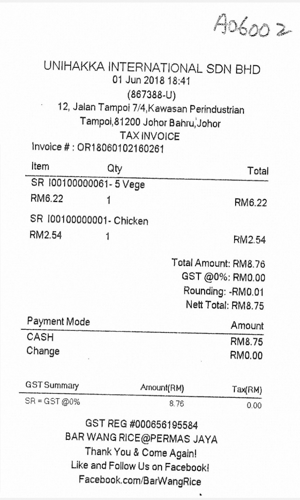

Here is the extracted key-value information from the image:

- **Company**: UNIHAKKA INTERNATIONAL SDN BHD
- **Date**: 01 Jun 2018
- **Address**: 12, Jalan Tampoi 7/4,Kawasan Perindustrian Tampoi,81200 Johor Bahru,Johor
- **Item Name**:
  - SR I00100000061-5 Vege
  - SR I00100000001-Chicken
- **Invoice Number**: OR18060102160261
- **Total**: RM8.75
- **Last Line**: GST REG #000656195584 BAR WANG RICE@PERMAS JAYA Thank You & Come Again! Like and Follow Us on Facebook! Facebook.com/BarWangRice

In [9]:
image_path = "/mnt/workspace/LLaMA-Factory/test_image/ocr_example3.jpg"
prompt = "Extract the key-value information in the format:{\"company\": \"\",\"date\": \"\", \"address\": \"\", \"item_name\": \"\",\"invoice_number\": \"\",\"total\": \"\",\"Last_line\": \"\"}"

image = Image.open(image_path)
display(image.resize((300,500)))

## Use a local HuggingFace model to inference.
# response = inference(image_path, prompt)
# display(Markdown(response))


## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
response = inference_with_api(image_path, prompt)
display(Markdown(response))

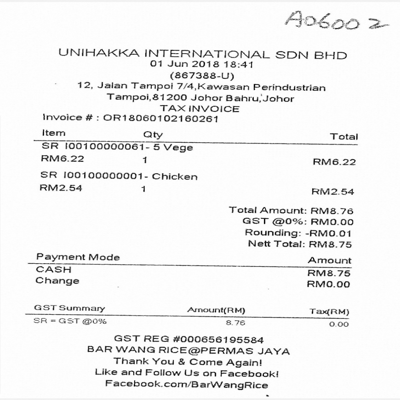

代码运行耗时: 7.831185 秒


```json
{
    "Company": "UNIHAKKA INTERNATIONAL SDN BHD",
    "date": "01 Jun 2018 18:41",
    "address": "12, Jalan Tampoi 7/4,Kawasan Perindustrian Tampoi,81200 Johor Bahru,Johor",
    "invoice_number": "OR18060102160261",
    "item_number_with_price": [
        {
            "Item Number": "SR I00100000061- 5 Vege",
            "Price": "RM6.22"
        },
        {
            "Item Number": "SR I00100000001- Chicken",
            "Price": "RM2.54"
        }
    ],
    "Total Amount": "RM8.75",
    "Payment mode": "CASH",
    "website_link": "Facebook.com/BarWangRice"
}
```

In [35]:
import time
start = time.time()
image_path = "/mnt/workspace/LLaMA-Factory/test_image/ocr_example3.jpg"
prompt = "提取图中的：['Company','date','address','invoice_number','item_number_with_price','Total Amount','Payment mode','website_link']，out put in Json type。"

image = Image.open(image_path)
display(image.resize((400,400)))

## Use a local HuggingFace model to inference.
# response = inference(image_path, prompt)
# display(Markdown(response))


## Use an API-based approach to inference.
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here'
response = inference_with_api(image_path, prompt)
end = time.time()
elapsed_time = end - start
print(f"代码运行耗时: {elapsed_time:.6f} 秒")
display(Markdown(response))

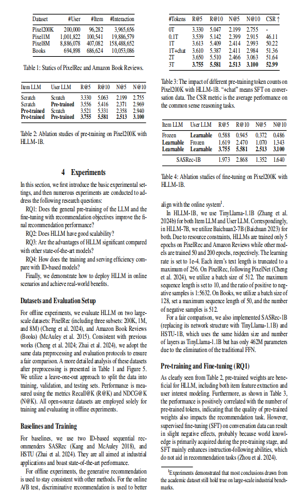

<class 'str'>


图片中的文字和表格如下：

### 文字内容

**4 Experiments**

In this section, we first introduce the basic experimental settings, and then numerous experiments are conducted to address the following research questions:

RQ1: Does the general pre-training of the LLM and the fine-tuning with recommendation objectives improve the final recommendation performance?

RQ2: Does HLLM have good scalability?

RQ3: Are the advantages of HLLM significant compared with other state-of-the-art models?

Finally, we demonstrate how to deploy HLLM in online scenarios and achieve real-world benefits.

**Datasets and Evaluation Setup**

For offline experiments, we evaluate HLLM on two large-scale datasets: PixelRec (including three subsets: 200K, 1M, and 8M) (Cheng et al., 2024), and Amazon Book Reviews (Books) (McAuley et al., 2015). Consistent with previous works (Cheng et al., 2024; Zhuai et al., 2024), we adopt the same data preprocessing and evaluation protocols to ensure fair comparison. A more detailed description of these datasets after pre-processing is provided in Table 1. We utilize a leave-one-out approach to split the data into training, validation, and testing sets. Performance is measured using the metrics Recall@K (R@K) and NDCG@K (N@K). All open-source datasets are employed solely for training and evaluating in offline experiments.

**Baselines and Training**

For baselines, we use two ID-based sequential recommenders SASRec (Kang and McAuley 2018) and HSTU (Zhai et al., 2024). They are all aimed at industrial applications and boast state-of-the-art performance.

For ablation experiments, the generative recommendation is used to stabilize the model during training, while the online A/B test, discriminative recommendation is used to better align with the online system.

In HLLM-IB, we use TinyLlama-1.1B (Zhang et al., 2024b) for both item LLM and user LLM. Correspondingly, in HLLM-7B, we utilize Baichuan-2-7B (Baichuan 2023) for both. Due to resource constraints, HLLMs are trained only 5 epochs on PixelRec and Amazon Reviews while other models are trained 50 and 200 epochs, respectively. The learning rate is set to 1e-4. Each item's text length is truncated to a maximum of 256. On PixelRec, following FineNet (Cheng et al., 2024), the maximum sequence length is set to 512, and the ratio of positive to negative samples is 1:5632. On Books, we utilize a batch size of 128, set a maximum sequence length of 50, and the number of negative samples is 512.

For a fair comparison, we also implemented SASRec-1B (replacing its network structure with TinyLlama-1.1B) and HSTU-1B, which uses the same hidden size and number of layers as TinyLlama-1.1B but has only 46.2M parameters due to the elimination of the traditional FPN.

**Pre-training and Fine-tuning (RQ1)**

As clearly seen from Table 2, pre-trained weights are beneficial for HLLM, including both item feature extraction and user interest modeling. Furthermore, as shown in Table 3, the performance is positively correlated with the number of pre-trained tokens, indicating that the quality of pre-trained weights also impacts the recommendation task. However, supervised fine-tuning (SFT) generally results in slight negative effects, presumably because world knowledge is primarily acquired during the pre-training stage, and SFT mainly enhances instruction-following abilities, which do not aid in recommendation tasks (Zhou et al., 2024).

1. Experiments demonstrated that most conclusions drawn from the academic dataset still hold true on large-scale industrial benchmarks.

### 表格内容

#### 表1: PixelRec和Amazon Book Reviews的统计信息

| Dataset | #User | #Item | #Interaction |
|---------|-------|-------|--------------|
| Pixel200K | 200,000 | 96,282 | 3,965,656 |
| Pixel1M | 1,000,000 | 159,622 | 15,965,379 |
| Pixel8M | 8,886,072 | 407,082 | 158,488,652 |
| Books | 694,898 | 686,624 | 10,053,086 |

#### 表2: 在Pixel200K上使用HLLM-1B的预训练研究

| Item LLM | User LLM | R@5 | R@10 | N@5 | N@10 |
|----------|----------|-----|------|-----|------|
| Scratch | Scratch | 3,330 | 5,063 | 2,199 | 2,755 |
| Scratch | Pre-trained | 3,556 | 5,416 | 2,371 | 2,969 |
| Pre-trained | Scratch | 3,755 | 5,581 | 2,513 | 3,100 |
| Pre-trained | Pre-trained | 3,755 | 5,581 | 2,513 | 3,100 |

#### 表3: 不同预训练词元对Pixel200K上HLLM-1B的影响

| Tokens | R@5 | R@10 | N@5 | N@10 | CSR ↑ |
|--------|-----|------|-----|------|------|
| 0T     | 3,330 | 5,067 | 2,199 | 2,755 | - |
| 1T     | 3,539 | 5,142 | 2,351 | 3,015 | 46.11 |
| 1T+chat | 3,613 | 5,409 |

In [18]:
image_path = "/mnt/workspace/Qwen-Agent/image/essay_screenShot.png"
prompt = "提取图片中的文字和表格，注意表格的结构"

image = Image.open(image_path)
display(image.resize((300,500)))

## Use a local HuggingFace model to inference.
# response = inference(image_path, prompt)
# display(Markdown(response))


## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
response = inference_with_api(image_path, prompt)
print(type(response))
display(Markdown(response))

In [23]:
!pip install pillow

Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple
DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [33]:
!pip install time

Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple
ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time

[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [61]:
from PIL import Image


def crop_image(image_path, grid_rows, grid_cols):
    img = Image.open(image_path)
    w, h = img.size
    step_w, step_h = w//grid_cols, h//grid_rows
    crops = []
    for i in range(grid_rows):
        for j in range(grid_cols):
            box = (j*step_w, i*step_h,
                   (j+1)*step_w if j<grid_cols-1 else w,
                   (i+1)*step_h if i<grid_rows-1 else h)
            crops.append((i*grid_cols+j+1, img.crop(box)))
    return crops



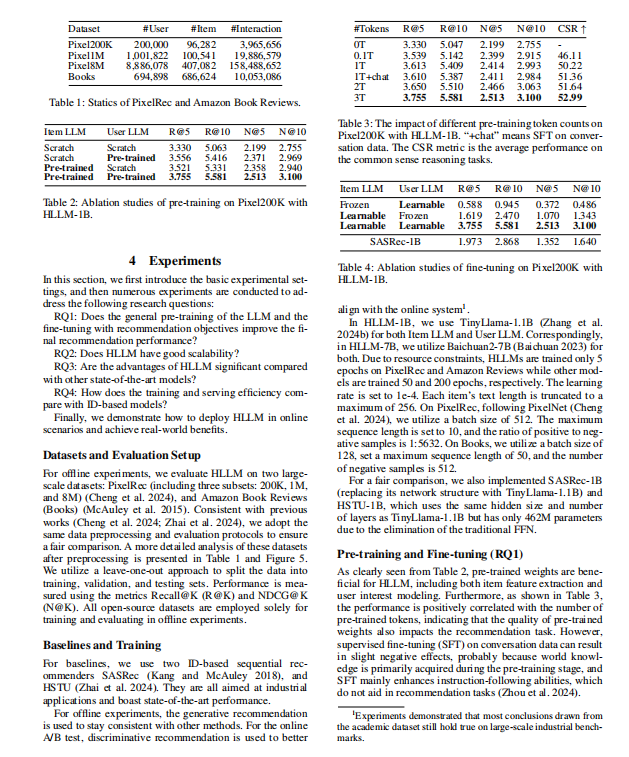

Table 1: Statistics of PixelRec and Amazon Book Reviews.
| Dataset | #User | #Item | #Interaction |
|---------|-------|-------|--------------|
| Pixel200K | 200,000 | 96,282 | 3,965,656 |
| Pixel1M | 1,001,857 | 100,541 | 9,836,579 |
| Pixel3M | 8,839,978 | 100,541 | 15,048,652 |
| Books | 694,898 | 686,624 | 10,053,086 |

Table 2: Ablation studies of pre-training on Pixel200K with HLLM-IB.
| Item LLM | User LLM | R@5 | R@10 | N@5 | N@10 |
|----------|----------|-----|------|-----|------|
| Scratch | Scratch | 3.330 | 5.063 | 2.199 | 2.755 |
| Scratch | Pre-trained | 3.546 | 5.416 | 2.371 | 2.969 |
| Pre-trained | Scratch | 3.521 | 5.331 | 2.538 | 2.940 |
| Pre-trained | Pre-trained | 3.755 | 5.581 | 2.513 | 3.100 |

4 Experiments
In this section, we first introduce the basic experimental settings, and then numerous experiments are conducted to address the following research questions:
RQ1: Does the general pre-training of the LLM and the fine-tuning with recommendation objectives impr

In [64]:
image_path = "/mnt/workspace/Qwen-Agent/image/essay_screenShot.png"
image = Image.open(image_path)
display(image.resize((629,757)))
start = time.time()
blocks = crop_image(image_path, grid_rows=2, grid_cols=2)
messages = []
results = {}

for idx, block in blocks:
    # 生成 prompt
    prompt = (
    "你是一个信息抽取专家，请仅提取图像中的文字和表格内容，不要输出任何额外的说明性语句、引导语、客套话或总结性语言。"
    "请按图中文本出现的顺序整理内容，遇到重复表格请跳过。"
    )
    # prompt = (
    # "你是一个信息抽取专家，请仅提取图像中的文字和表格内容，不要输出任何额外的说明性语句、引导语、客套话或总结性语言。"
    # "请按图中文本出现的顺序整理内容，遇到重复表格请跳过。"
    # )
    # prompt = (
    #     f"这是第 {idx} 块图，请基于上面结果继续提取文字和表格，"
    #      f"只输出本块新增内容，不要重复已有表格；保持输出结构与原文顺序一致。"
    # )
    # 带上上下文 messages 调用
    response = inference_with_api_with_image(
        block,
        prompt=prompt,
        history_messages=messages
    )
    # 保存结果
    results[idx] = response
    # 把这轮的 assistant 回复加入上下文
    # messages.append({"role": "assistant", "content": response})
full_response = "\n\n".join(results[i] for i in sorted(results))
print(full_response)
end = time.time()
elapsed_time = end - start
print(f"代码运行耗时: {elapsed_time:.6f} 秒")

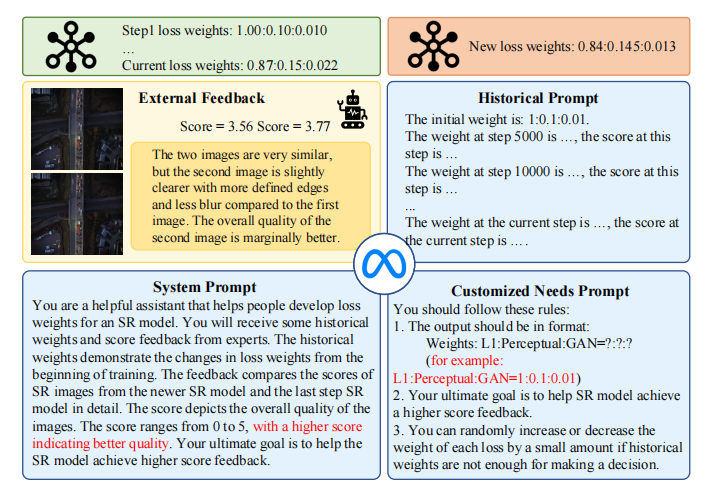

Step1 loss weights: 1.00:0.10:0.010
Current loss weights: 0.87:0.15:0.022

External Feedback
Score = 3.56 Score = 3.77
The two images are very similar, but the second image is slightly clearer with more defined edges and less blur compared to the first image. The overall quality of the second image is marginally better.

New loss weights: 0.84:0.145:0.013

Historical Prompt

The initial weight is: 1:0.1:0.01.

The weight at step 5000 is ..., the score at this step is ...

The weight at step 10000 is ..., the score at this step is ...

...

The weight at the current step is ..., the score at the current step is ...

System Prompt
You are a helpful assistant that helps people develop loss weights for an SR model. You will receive some historical weights and score feedback from experts. The historical weights demonstrate the changes in loss weights from the beginning of training. The feedback compares the scores of SR images from the newer SR model and the last step SR model in detail. Th

In [63]:
image_path = "/mnt/workspace/Qwen-Agent/image/lossagent.png"
image = Image.open(image_path)
display(image.resize((715,491)))
start = time.time()
blocks = crop_image(image_path, grid_rows=2, grid_cols=2)
messages = []
results = {}

for idx, block in blocks:
    # 生成 prompt
    
    prompt = (
    "你是一个信息抽取专家，请仅提取图像中的文字和图表，不要输出任何额外的说明性语句、引导语、客套话或总结性语言。"
    "请按图中文本出现的顺序整理内容，遇到重复表格请跳过。"
    )
    # prompt = (
    #     f"这是第 {idx} 块图，请基于上面结果继续提取文字和表格，"
    #      f"只输出本块新增内容，不要重复已有表格；保持输出结构与原文顺序一致。"
    # )
    # 带上上下文 messages 调用
    response = inference_with_api_with_image(
        block,
        prompt=prompt,
        history_messages=messages
    )
    # 保存结果
    results[idx] = response
    # 把这轮的 assistant 回复加入上下文
    # messages.append({"role": "assistant", "content": response})
full_response = "\n\n".join(results[i] for i in sorted(results))
print(full_response)
end = time.time()
elapsed_time = end - start
print(f"代码运行耗时: {elapsed_time:.6f} 秒")

In [ ]:
image_path = "/mnt/workspace/Qwen-Agent/image/essay_screenShot.png"
start = time.time()
# 切成 2×2 四块
blocks = crop_image(image_path, grid_rows=2, grid_cols=2)
results = {}
for idx, block in blocks:
    # 将 block 临时保存或转 base64 直接传到接口
    res = inference_with_api_with_image(block, prompt=f"提取图片中的文字和表格,只保留首次出现的表格，不要重复同样的表格；请保持输出结构与原文顺序一致。")
    # res = inference_with_api_with_image(block, prompt=f"这是第 {idx} 块图，提取文字和表格")
    results[idx] = res
full_response = "\n\n".join(results[i] for i in sorted(results))
end = time.time()
elapsed_time = end - start
print(f"代码运行耗时: {elapsed_time:.6f} 秒")
display(Markdown(full_response))

In [15]:
from PIL import Image

def split_image(image_path, chunk_height=500):
    image = Image.open(image_path)
    width, height = image.size
    chunks = []
    for y in range(0, height, chunk_height):
        # 分割图像，保留部分重叠（如50像素）避免内容断裂
        chunk = image.crop((0, y, width, min(y + chunk_height + 50, height)))
        chunks.append(chunk)
    return chunks

def parse_response(response):
    """
    将模型返回的字符串解析为字典。
    示例输入："{\"table_rows\": [[\"header1\", \"header2\"], [\"value1\", \"value2\"]]}"
    输出：{"table_rows": [["header1", "header2"], ["value1", "value2"]]}
    """
    try:
        parsed_data = eval(response)  # 尝试将字符串转换为字典
        if isinstance(parsed_data, dict):
            return parsed_data
    except Exception:
        pass
    # 如果无法解析，返回默认值
    return {"table_rows": []}

def inference_with_api_incremental(image_chunks, prompt, sys_prompt, model_id):
    all_results = []
    for i, chunk in enumerate(image_chunks):
        # 保存临时分块图像
        chunk_path = f"/tmp/chunk_{i}.png"
        chunk.save(chunk_path)
        
        # 构建动态提示词，包含已提取内容
        current_prompt = f"{prompt}\n\n已提取内容：{all_results}\n请继续处理第{i+1}部分："
        
        # 调用API
        response = inference_with_api(
            chunk_path,
            current_prompt,
            sys_prompt,
            model_id,
            min_pixels=512*28*28,
            max_pixels=2048*28*28
        )
        
        # 解析响应
        parsed_result = parse_response(response)
        all_results.append(parsed_result)
    return all_results

import re

def merge_results(results):
    merged_table = []
    for result in results:
        # 假设表格行以特定格式输出，如 "Row: [data1, data2, ...]"
        rows = re.findall(r"Row: \[(.*?)\]", result)
        for row in rows:
            # 解析表格行数据
            merged_table.append(eval(row))  # 注意：eval 仅适用于简单场景，生产环境建议使用安全解析方法
    return {"full_table": merged_table}

In [20]:
# 分割图像
image_chunks = split_image(image_path, chunk_height=500)

# 递归推理
all_responses = inference_with_api_incremental(
    image_chunks,
    prompt="提取图片中的文字和表格，注意表格的结构",
    sys_prompt="You are a helpful assistant.",
    model_id="Qwen2.5-VL-7B-Instruct"
)

# 合并结果
final_result = merge_results(all_responses)
display(Markdown(final_result))

AttributeError: 'str' object has no attribute 'get'